to do

* outliers niet uit test set halen
* met opvullen kijken we naar omliggende waardes, is dat fair in de test set? want in realiteit kan dat niet... dan wil je alleen naar voorafgaande waardes kijken

* test set behandelen alsof je nog niks weet want is in theorie nog niet gebeurd.


* week before prediction
* 2 week before
* month before
* etc...

voor 1 week prediction je 1 week lag model gebruiken. voor je 2 weken prediction die van 2 gebruiken en dan voor je 1. wk je 1 wk model gebruiken. dus je gebruikt meerdere modellen. zo gebruik je steeds nieuwste data.

In [1]:
from google.colab import drive
import os, sys
drive.mount('/content/drive/')

Mounted at /content/drive/


# Imports

In [24]:
import pandas as pd
from scipy.stats import pearsonr
import datetime

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import holidays

from prophet import Prophet
import math
from sklearn.metrics import mean_squared_error

from typing import Optional, Any, Tuple, List

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# fix random seed for reproducibility
tf.random.set_seed(7)

import warnings
warnings.filterwarnings("ignore")

# Preprocessing

In [ ]:
"""
Step 1: before data splitting
* read data
* encode strings
* create national holiday flag
* find numerical columns
"""

def read_processed_data() -> pd.DataFrame:
  df = pd.read_csv('/content/drive/MyDrive/master_thesis_data/preprocessed_data.csv')
  df.drop(columns=[
      'Unnamed: 0',
      'Aardgas_Variabel_leveringstarief_prijsplafond_(Euro_m3)',
      'Elektriciteit_Variabel_leveringstarief_prijsplafond_(Euro_kWh)',
      'Statistische overdracht', 'Hour', 'Year',
      'Week', 'WeekKey', 'day_of_week', 'Month', 'Biomassa', 'Windenergie',
      'Zonne-energie', 'Warmtepompen', 'Overig'], inplace=True)
  df['DateUTC'] = pd.to_datetime(df['DateUTC'])
  return df


# def encode_string_columns(df: pd.DataFrame) -> pd.DataFrame:
#   """OHE the day of week (string) column."""
#   OHE = OneHotEncoder(sparse=False)
#   onehot_encoded = OHE.fit_transform(df[['day_of_week']])
#   onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=[f'day_of_week_{i}' for i in range(onehot_encoded.shape[1])])

#   df = pd.concat([df, onehot_encoded_df], axis=1)
#   df.drop(columns=['day_of_week'], inplace=True)
#   df.drop(columns=['Biomassa', 'Windenergie', 'Zonne-energie', 'Warmtepompen', 'Overig'], inplace=True)
#   return df


def create_national_holiday_and_event_flag(df: pd.DataFrame) -> pd.DataFrame:
  """Create a flag for Dutch national holidays.
  Also flag all the days after the Ukraine Russia war started."""
  dutch_holidays = holidays.NL()
  df['NationalHolidayFlag'] = df['Date'].apply(lambda x: 1 if dutch_holidays.get(x) is not None  else 0)

  date_war_ukraine_russia = datetime.date(2022, 2, 24)
  df['Date'] = pd.to_datetime(df['Date']).dt.date
  df['SpecialEventFlag'] = df['Date'].apply(lambda x: 1 if x >= date_war_ukraine_russia else 0)
  df.drop(columns=['Date'], inplace=True)
  return df


def find_numerical_columns(df: pd.DataFrame) -> list:
  """Find the numerical columns (int or float) in the given df."""
  return df.select_dtypes(include=['int64', 'float64']).columns.tolist()


"""
Step 2: remove outliers from train part of load consumption
We decide for now not to remove outliers from any of the rest of the data. Since things about weather and price are just things that are realistic to happen.
"""

def clear_outliers(df: pd.DataFrame, numerical_columns: list, start_winter: datetime.datetime) -> pd.DataFrame:
  """
  Use IQR to detect the outliers.
  Next, set them to nan.
  """
  df_train = df[df['DateUTC'] < start_test_wintertime]
  df_test = df[df['DateUTC'] >= start_test_wintertime]
  df_numerical_columns = df_train[numerical_columns]

  q1 = df_numerical_columns.quantile(0.25)
  q3 = df_numerical_columns.quantile(0.75)

  IQR = q3 - q1

  lower_bound = q1 - 1.5 * IQR
  upper_bound = q3 + 1.5 * IQR

  for col in numerical_columns:
    outliers = (df_train[col] < lower_bound[col]) | (df_train[col] > upper_bound[col])
    df_train.loc[outliers, col] = pd.NA

  df_merged = pd.concat([df_train, df_test])
  return df_merged

"""
Step 3: shift data
2 month ahead value
"""

def shift_data(df: pd.DataFrame, n_days_lag: int ) -> pd.DataFrame:
  """Shift the predictors in the dataset,
  except for y and ds and the features that are known beforehand."""

  all_columns = list(df.columns)
  all_columns.remove('DateUTC')
  # all_columns.remove('Date')

  df_lag = df.copy()
  lag = n_days_lag * 24

  df_lag.sort_values('DateUTC', inplace=True)

  for i in all_columns:
    if i not in known_features_list:
      df_lag[f"{i}-{n_days_lag}days"] = df_lag[i].shift(lag)
      if (i != 'LoadConsumption'):
        df_lag.drop(columns=[i], inplace=True)


  df_lag = df_lag.iloc[lag:]
  df_lag.reset_index(inplace=True, drop=True)

  return df_lag

"""
Step 4: split data

We do this now before the other processing step to prevent data leakage.
"""

def split_train_val_test(df: pd.DataFrame, start_test_wintertime: datetime.date) -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Split the df into train/val and test data."""
  df['DateUTC'] = pd.to_datetime(df['DateUTC'])
  df_test = df[df['DateUTC'] >= start_test_wintertime]
  df_train_val = df[df['DateUTC'] < start_test_wintertime]

  df_test.reset_index(inplace=True, drop=True)

  return (df_test, df_train_val)


"""
Step 5: impute numerical columns
"""

def impute_numerical_columns(df_train_val: pd.DataFrame, df_test: pd.DataFrame, numerical_columns: List, n_days_lag: int) -> Tuple[pd.DataFrame, pd.DataFrame, List]:
  numerical_columns_lagged = [f"{i}-{n_days_lag}days" if i not in known_features_list else i for i in numerical_columns]

  # impute load consumption with fit transform
  imputer = IterativeImputer(max_iter=10, random_state=0)
  df_train_val['LoadConsumption_imputed'] = imputer.fit_transform(df_train_val[['LoadConsumption']])
  df_train_val['LoadConsumption'] = df_train_val.apply(lambda row:
                                                      row['LoadConsumption']
                                                      if pd.notnull(row['LoadConsumption'])
                                                      else row['LoadConsumption_imputed'],
                                                      axis=1)

  #tmp rename column to be able to use the transform from LoadConsumption
  df_train_val_tmp = df_train_val[['DateUTC', f'LoadConsumption-{n_days_lag}days']]
  df_train_val_tmp.rename(columns={f'LoadConsumption-{n_days_lag}days':'LoadConsumption'}, inplace=True)

  # impute load consumption lagged with transform
  df_train_val_tmp['LoadConsumption_imputed'] = imputer.transform(df_train_val[['LoadConsumption']])
  df_train_val_tmp['LoadConsumption'] = df_train_val_tmp.apply(lambda row:
                                                                row['LoadConsumption']
                                                                if pd.notnull(row['LoadConsumption'])
                                                                else row['LoadConsumption_imputed'],
                                                                axis=1)
  df_train_val_tmp.drop(columns=['LoadConsumption_imputed'], inplace=True)

  # rename back to old name
  df_train_val_tmp.rename(columns={'LoadConsumption':f'LoadConsumption-{n_days_lag}days'}, inplace=True)

  # merge to df
  df_train_val.drop(columns=[f'LoadConsumption-{n_days_lag}days'], inplace=True)
  df_train_val = df_train_val.merge(df_train_val_tmp, on = 'DateUTC', how = 'left')
  df_train_val.drop(columns=['LoadConsumption_imputed'], inplace=True)

  numerical_columns_lagged.remove(f'LoadConsumption-{n_days_lag}days')

  imputed_columns = []

  for i in numerical_columns_lagged:
    imputer = IterativeImputer(max_iter=10, random_state=0)
    df_train_val[f'{i}_imputed'] = imputer.fit_transform(df_train_val[[i]])
    df_train_val[i] = df_train_val.apply(lambda row: row[i] if pd.notnull(row[i]) else row[f'{i}_imputed'], axis=1)
    df_train_val.drop(columns=[f'{i}_imputed'], inplace=True)

    df_test[f'{i}_imputed'] = imputer.transform(df_test[[i]])
    df_test[i] = df_test.apply(lambda row: row[i] if pd.notnull(row[i]) else row[f'{i}_imputed'], axis=1)
    df_test.drop(columns=[f'{i}_imputed'], inplace=True)


  return (df_train_val, df_test, numerical_columns_lagged)


"""
Step 6: Predictor selection
"""
def select_top_n_correlated_predictors(df: pd.DataFrame, numerical_columns: list, n_predictors: int, alpha: float) -> dict:
    """Select the top n predictors based on their Pearson correlation coefficient and return their correlation
    coefficients and p-values in a dictionary."""

    predictors_dict = {}
    for predictor in numerical_columns:
      if predictor != 'LoadConsumption':
        corr, p_value = pearsonr(df['LoadConsumption'], df[predictor])
        if p_value < alpha:
            predictors_dict[predictor] = {'corr': corr, 'p_value': p_value}

    sorted_items = sorted(predictors_dict.items(), key=lambda x: abs(x[1]['corr']), reverse=True)

    selected_predictors = {}
    for key, value in sorted_items[:n_predictors]:
        selected_predictors[key] = value

    predictors_list = list(selected_predictors.keys())
    print(f"These are top {n_predictors} predictors: ", predictors_list)

    return selected_predictors, predictors_list


"""
Step 7: feature selection
"""
def prepare_data_for_prophet(
    df: pd.DataFrame,
    top_n_predictors_list: list,
    use_top_n_predictors: bool,
    use_all_predictors: bool,
    use_no_predictors: bool,
    n_days_lag: int) -> pd.DataFrame:
  """Select the predictors from the df and rename date to ds and load to y."""

  if use_all_predictors:
    print("All predictors are used")
    df_prophet = df.copy()

  if use_top_n_predictors:
    print("Top n predictors are used")
    cols_to_select = top_n_predictors_list.copy()
    cols_to_select.append('DateUTC')
    cols_to_select.append('LoadConsumption')
    df_prophet = df[cols_to_select]

  if use_no_predictors:
    print("No predictors are used")
    df_prophet = df[['DateUTC', f'LoadConsumption-{n_days_lag}days', 'LoadConsumption']]

  df_prophet.rename(columns={'DateUTC':'ds', 'LoadConsumption':'y'}, inplace=True)

  return df_prophet


def preprocess_data(
    n_predictors: int,
    alpha: float,
    use_top_n_predictors: bool,
    use_all_predictors: bool,
    use_no_predictors: bool,
    known_features_list: list,
    start_test_wintertime: datetime.datetime,
    n_days_lag: int):
  """Run all data preprocessing steps."""

  df = read_processed_data()
  # df_encoded = encode_string_columns(df)
  df_flagged = create_national_holiday_and_event_flag(df)
  numerical_columns = find_numerical_columns(df_flagged)

  df_flagged_outliers_cleared = clear_outliers(df_flagged, numerical_columns=['LoadConsumption'], start_winter=start_test_wintertime)

  df_lag = shift_data(df_flagged_outliers_cleared, n_days_lag)

  (df_test, df_train_val) = split_train_val_test(df_lag, start_test_wintertime)

  (df_train_val, df_test, numerical_columns_lagged) = impute_numerical_columns(df_train_val, df_test, numerical_columns, n_days_lag)

  if use_top_n_predictors:
    predictors_dict, predictors_list = select_top_n_correlated_predictors(df_train_val, numerical_columns_lagged, n_predictors, alpha)

  elif use_all_predictors:
    predictors_list = list(df_train_val.columns)
    predictors_list.remove('DateUTC')
    predictors_list.remove('LoadConsumption')

  else:
    predictors_list = []


  df_train_prophet = prepare_data_for_prophet(
      df=df_train_val,
      top_n_predictors_list=predictors_list,
      use_top_n_predictors=use_top_n_predictors,
      use_all_predictors=use_all_predictors,
      use_no_predictors=use_no_predictors,
      n_days_lag=n_days_lag
  )

  df_test_prophet = prepare_data_for_prophet(
      df=df_test,
      top_n_predictors_list=predictors_list,
      use_top_n_predictors=use_top_n_predictors,
      use_all_predictors=use_all_predictors,
      use_no_predictors=use_no_predictors,
      n_days_lag=n_days_lag
  )

  return df_train_prophet, df_test_prophet, predictors_list

# Prophet

In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


"""
Step 8: Prophet model: train Prophet on the training data.
Use the trained Prophet model to make predictions for the entire dataset,
including both training and test sets.
"""

def initialize_prophet(
    regressors: list,
    add_seasonality: bool,
    fourier_weekly: Optional[int],
    fourier_annual: Optional[int],
    automatic: bool):
    """
    Initialize prophet. Either with specified seasonalities or default.
    Add regressors if any are entered.
    """
    if add_seasonality:
        if automatic:
            model = Prophet(
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=True,
            )
        else:
            model = Prophet(
                daily_seasonality=False,
                weekly_seasonality=fourier_weekly,
                yearly_seasonality=fourier_annual,
            )

    else:
        model = Prophet()

    if len(regressors) > 0:
        for regressor in regressors:
            model.add_regressor(regressor)

    return model

"""
Step 9: Feature engineering

Combine the Prophet predictions with other relevant features (such as temperature, energy price) to create the feature set for the LSTM model.
Scale the features if necessary to ensure that they have similar ranges.
"""

def combine_prophet_predictions_and_target(prophet_forecast, df_subset, prophet_columns_to_select, predictors_to_select):
  """
  Combine the results from Prophet with the target LoadConsumption.
  """

  df_subset['ds'] = pd.to_datetime(df_subset['ds'], format='%Y-%m-%d %H:%M:%S')
  df_subset = df_subset[['ds', 'y']]

  df_prophet = prophet_forecast.merge(df_subset, on='ds', how='left')
  cols_to_select = predictors_to_select + prophet_columns_to_select
  cols_to_select.append('y')
  df_prophet_subset = df_prophet[cols_to_select]
  # df_prophet_subset.set_index('ds', inplace=True)
  df_prophet_subset.rename(columns={'y':'LoadConsumption'}, inplace=True)
  return df_prophet_subset

# LSTM

In [27]:
"""
Step 10: LSTM model

Define an LSTM architecture suitable for forecasting time series data.
Split the training set into k folds for cross-validation.
"""

def fit_model(model, train_X, train_y, test_X, test_y, epochs, batch_size):
  """
  Fit model and show plot of training process.
  """
  history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)

  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  return model

def inverse_transform_predictions(scaler, data, colName, colNames):
  dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
  dummy[colName] = data
  dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
  return dummy[colName].values


def predict(model, test_X, scaler, df):
  """Make predictions and inverse them to scale them back"""

  yhat = model.predict(test_X)

  yhat_inversed = inverse_transform_predictions(scaler=scaler, data=yhat, colName='LoadConsumption_scaled', colNames=df.columns)

  return yhat, yhat_inversed

def evaluate_predictions(test_y, yhat_inversed, scaler, df):
  test_y_inversed = inverse_transform_predictions(scaler=scaler, data=test_y, colName='LoadConsumption_scaled', colNames=df.columns)

  mape = np.mean(np.abs((test_y_inversed - yhat_inversed) / test_y_inversed)) * 100
  rmse = np.sqrt(mean_squared_error(test_y_inversed, yhat_inversed))
  corr_test, p_value_test = pearsonr(test_y_inversed, yhat_inversed)
  print(f'MAPE: {mape}')
  print(f'RMSE: {rmse}')
  print(f'Correlation {corr_test} with p-value {p_value_test}')

  return mape, rmse, corr_test, p_value_test

# K-Fold Cross-Validation

For each fold:
1. Use the training portion of the data to train the LSTM model.
2. Apply the trained LSTM model to make predictions on the validation portion of the data.
3. Evaluate the performance of the model using appropriate metrics (e.g., RMSE, MAE) on the validation set.

Aggregate the performance metrics across all folds to assess the overall performance of the combined Prophet-LSTM model.


In [28]:
def train_with_k_fold_cv(k_folds, df_lstm, train, test, huang, tan):
  tscv = TimeSeriesSplit(n_splits=k_folds)

  rmse_list = []
  corr_list = []
  mape_list = []

  for train_idx, test_idx in tscv.split(df_lstm):
    end_train_idx, start_test_idx = train_idx.max(), test_idx.min()
    train, test = df_lstm.iloc[:end_train_idx,:], df_lstm.iloc[start_test_idx-1:,:]

    train.set_index('ds', inplace=True)
    test.set_index('ds', inplace=True)

    # scale data
    scaler = MinMaxScaler(feature_range=(0, 1))

    train_scaled = scaler.fit_transform(train)
    df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in train.columns])

    test_scaled = scaler.transform(test)
    df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in test.columns])

    # reorder columns
    cols_ordered = list(df_train_scaled)
    cols_ordered.remove('LoadConsumption_scaled')
    cols_ordered.append('LoadConsumption_scaled')
    df_train_scaled = df_train_scaled[cols_ordered]
    df_test_scaled = df_test_scaled[cols_ordered]

    # split into X and y
    train_values = df_train_scaled.values
    test_values = df_test_scaled.values

    train_X, train_y = train_values[:, :-1], train_values[:, -1]
    test_X, test_y = test_values[:, :-1], test_values[:, -1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # compile LSTM
    if huang:
      model = Sequential()
      # probeer 30/90 25/75
      # dropout minder features?
      model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
      model.add(LSTM(150, activation='relu'))
      model.add(Dense(1))
      model.compile(optimizer='adam', loss='mse')
    if tan:
      model = Sequential()
      model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
      model.add(LSTM(30, activation='sigmoid', return_sequences=True, name='LSTM_Layer_1'))
      model.add(Dropout(rate=0.2, name='Dropout_Layer_0.2'))
      model.add(LSTM(60, activation='tanh', name='LSTM_Layer_2'))
      model.add(Dropout(rate=0.3, name='Dropout_Layer_0.3'))
      model.add(Dense(1, activation='linear', name='Dense_Layer'))
      model.compile(optimizer='rmsprop', loss='mse')

    # fit LSTM to fold
    model = fit_model(model, train_X, train_y, test_X, test_y, epochs=8, batch_size=8)

    # predict with LSTM to fold
    yhat, yhat_inversed = predict(model, test_X, scaler, df=df_train_scaled)

    # evaluate
    mape, rmse, corr_test, p_value = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)

    mape_list.append(mape)
    rmse_list.append(rmse)
    corr_list.append([corr_test, p_value])

  return mape_list, rmse_list, corr_list



In [29]:
def run_setup(
    n_predictors: int,
    alpha: float,
    use_top_n_predictors: bool,
    use_all_predictors: bool,
    use_no_predictors: bool,
    known_features_list: list,
    start_test_wintertime: datetime.datetime,
    n_days_lag: int,
    add_seasonality: bool,
    fourier_weekly: Optional[int],
    fourier_annual: Optional[int],
    automatic: bool,
    k_folds: int,
    huang: bool,
    tan: bool,
    ):

  df_train_prophet, df_test_prophet, predictors_list = preprocess_data(
      n_predictors=n_predictors,
      alpha=alpha,
      use_top_n_predictors=use_top_n_predictors,
      use_all_predictors=use_all_predictors,
      use_no_predictors=use_no_predictors,
      known_features_list=known_features_list,
      start_test_wintertime=start_test_wintertime,
      n_days_lag=n_days_lag
  )

  # intialize model
  model = initialize_prophet(
      regressors=predictors_list,
      add_seasonality=add_seasonality,
      fourier_weekly=fourier_weekly,
      fourier_annual=fourier_annual,
      automatic=automatic
  )

  # fit model
  model.fit(df_train_prophet)

  predictions_train_validation = model.predict(df_train_prophet)
  predictions_wintertime = model.predict(df_test_prophet)

  # combine predictions
  df_lstm = combine_prophet_predictions_and_target(
    prophet_forecast=predictions_train_validation,
    df_subset=df_train_prophet,
    prophet_columns_to_select=['trend', 'additive_terms', 'yearly', 'weekly', 'daily', 'yhat', 'ds'],
    predictors_to_select=predictors_list
  )

  # # k fold cv
  mape_list, rmse_list, corr_list = [], [], []
  # mape_list, rmse_list, corr_list = train_with_k_fold_cv(
  #     k_folds=k_folds,
  #     df_lstm=df_lstm,
  #     train=df_train_prophet,
  #     test=df_test_prophet,
  #     huang=huang,
  #     tan=tan
  # )

  return mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet

In [42]:
from keras.callbacks import EarlyStopping

def run_full_model(df_lstm, df_test_prophet, huang, tan, predictors_list):
  df_lstm.set_index('ds', inplace=True)

  # scale data
  scaler = MinMaxScaler(feature_range=(0, 1))

  train_scaled = scaler.fit_transform(df_lstm)
  df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_lstm.columns])

  df_test = combine_prophet_predictions_and_target(
      prophet_forecast=predictions_wintertime,
      df_subset=df_test_prophet,
      prophet_columns_to_select=['trend', 'additive_terms', 'yearly', 'weekly', 'daily', 'yhat', 'ds'],
      predictors_to_select=predictors_list
  )

  df_test.set_index('ds', inplace=True)

  df_test = df_test[df_lstm.columns]
  test_scaled = scaler.transform(df_test)
  df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_test.columns])

  # reorder columns
  cols_ordered = list(df_train_scaled)
  cols_ordered.remove('LoadConsumption_scaled')
  cols_ordered.append('LoadConsumption_scaled')
  df_train_scaled = df_train_scaled[cols_ordered]
  df_test_scaled = df_test_scaled[cols_ordered]

  # split into X and y
  train_values = df_train_scaled.values
  test_values = df_test_scaled.values

  train_X, train_y = train_values[:, :-1], train_values[:, -1]
  test_X, test_y = test_values[:, :-1], test_values[:, -1]

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


  print(len(train_X), len(test_X))
  # compile LSTM
  if huang:
    model = Sequential()
    # probeer 30/90 25/75
    # dropout minder features?
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(150, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
  if tan:
    model = Sequential()
    model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
    model.add(LSTM(30, activation='sigmoid', return_sequences=True, name='LSTM_Layer_1'))
    model.add(Dropout(rate=0.2, name='Dropout_Layer_0.2'))
    model.add(LSTM(60, activation='tanh', name='LSTM_Layer_2'))
    model.add(Dropout(rate=0.3, name='Dropout_Layer_0.3'))
    model.add(Dense(1, activation='linear', name='Dense_Layer'))
    model.compile(optimizer='rmsprop', loss='mse')


  # fit LSTM to fold
  callback = EarlyStopping(monitor='loss',patience=3, start_from_epoch=10)
  history = model.fit(train_X, train_y, epochs=100, batch_size=8, verbose=2, shuffle=False, callbacks=[callback])

  # plot history
  plt.plot(history.history['loss'], label='train')
  # plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  yhat, yhat_inversed = predict(model, test_X, scaler, df=df_train_scaled)

  # evaluate
  mape, rmse, corr_test, p_value = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)

  # return mape, rmse, corr_test, p_value, yhat_inversed, yhat

# Set standard params

In [44]:
known_features_list = [
      # 'Hour', 'Year', 'Week', 'WeekKey', 'Month',
      # 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
      # 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
      'NationalHolidayFlag', 'SpecialEventFlag'
  ]
start_test_wintertime = datetime.datetime(2023, 12, 1, 0, 0, 0)
n_predictors=5
alpha=0.05
use_top_n_predictors=True
use_all_predictors=False
use_no_predictors=False
n_days_lag=60

# All predictors

### Tan

In [45]:
mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=True,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=False,
    tan=True
)

All predictors are used
                       ds           y  NationalHolidayFlag  SpecialEventFlag  \
0     2021-03-02 00:00:00  10937.0525                    0                 0   
1     2021-03-02 01:00:00  10833.9750                    0                 0   
2     2021-03-02 02:00:00  10807.7400                    0                 0   
3     2021-03-02 03:00:00  10970.1925                    0                 0   
4     2021-03-02 04:00:00  11400.2950                    0                 0   
...                   ...         ...                  ...               ...   
24097 2023-11-30 19:00:00  16063.3075                    0                 1   
24098 2023-11-30 20:00:00  15370.1250                    0                 1   
24099 2023-11-30 21:00:00  14699.8525                    0                 1   
24100 2023-11-30 22:00:00  14109.4925                    0                 1   
24101 2023-11-30 23:00:00  13508.1750                    0                 1   

       DailyPre

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/y2ismo6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/t2vuqs0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68871', 'data', 'file=/tmp/tmpd26ms1ki/y2ismo6b.json', 'init=/tmp/tmpd26ms1ki/t2vuqs0e.json', 'output', 'file=/tmp/tmpd26ms1ki/prophet_modelx_d92y8f/prophet_model-20240503085450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:54:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:55:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

ZeroDivisionError: division by zero

In [46]:
run_full_model(df_lstm=df_lstm, huang=False, tan=True, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

24138 744
Epoch 1/100


KeyboardInterrupt: 

### Huang

In [17]:
mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=True,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False
)

All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/2l5r8cxx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/xmengj_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=174', 'data', 'file=/tmp/tmpd26ms1ki/2l5r8cxx.json', 'init=/tmp/tmpd26ms1ki/xmengj_5.json', 'output', 'file=/tmp/tmpd26ms1ki/prophet_modelgb437r2f/prophet_model-20240503070917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:09:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:09:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

Epoch 1/100
3018/3018 - 15s - loss: 0.0118 - 15s/epoch - 5ms/step
Epoch 2/100
3018/3018 - 14s - loss: 0.0090 - 14s/epoch - 5ms/step
Epoch 3/100
3018/3018 - 11s - loss: 0.0084 - 11s/epoch - 4ms/step
Epoch 4/100
3018/3018 - 12s - loss: 0.0082 - 12s/epoch - 4ms/step
Epoch 5/100
3018/3018 - 12s - loss: 0.0081 - 12s/epoch - 4ms/step
Epoch 6/100
3018/3018 - 12s - loss: 0.0080 - 12s/epoch - 4ms/step
Epoch 7/100
3018/3018 - 12s - loss: 0.0079 - 12s/epoch - 4ms/step
Epoch 8/100
3018/3018 - 12s - loss: 0.0078 - 12s/epoch - 4ms/step
Epoch 9/100
3018/3018 - 13s - loss: 0.0078 - 13s/epoch - 4ms/step
Epoch 10/100
3018/3018 - 11s - loss: 0.0077 - 11s/epoch - 4ms/step
Epoch 11/100
3018/3018 - 12s - loss: 0.0076 - 12s/epoch - 4ms/step
Epoch 12/100
3018/3018 - 12s - loss: 0.0076 - 12s/epoch - 4ms/step
Epoch 13/100
3018/3018 - 12s - loss: 0.0076 - 12s/epoch - 4ms/step
Epoch 14/100
3018/3018 - 15s - loss: 0.0075 - 15s/epoch - 5ms/step
Epoch 15/100
3018/3018 - 12s - loss: 0.0075 - 12s/epoch - 4ms/step
Epoc

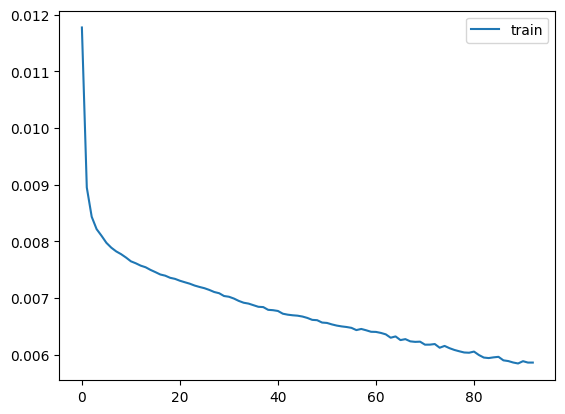

24/24 [==============================] - 0s 2ms/step
MAPE: 7.61546178776697
RMSE: 1384.3701810745604
Correlation 0.8112873234976666 with p-value 3.913983644457104e-175


In [18]:
run_full_model(df_lstm=df_lstm, huang=True, tan=False, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

# Top n predictors

### Tan

In [19]:
mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=True,
    use_all_predictors=False,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=False,
    tan=True
)

These are top 5 predictors:  ['sic-60days', 'NAO-60days', 'nat-60days', 'geopotential-60days', 'NationalHolidayFlag']
Top n predictors are used
Top n predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/ud8m8842.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/_w7prs8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42230', 'data', 'file=/tmp/tmpd26ms1ki/ud8m8842.json', 'init=/tmp/tmpd26ms1ki/_w7prs8o.json', 'output', 'file=/tmp/tmpd26ms1ki/prophet_modeldy6_z2pp/prophet_model-20240503072944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:29:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:30:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [79]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

avg rmse 1701.3239395488592
avg corr 0.6937858666025876
avg mape 11.041635874420924


Epoch 1/100
3018/3018 - 12s - loss: 0.0190 - 12s/epoch - 4ms/step
Epoch 2/100
3018/3018 - 8s - loss: 0.0125 - 8s/epoch - 3ms/step
Epoch 3/100
3018/3018 - 10s - loss: 0.0110 - 10s/epoch - 3ms/step
Epoch 4/100
3018/3018 - 9s - loss: 0.0104 - 9s/epoch - 3ms/step
Epoch 5/100
3018/3018 - 8s - loss: 0.0102 - 8s/epoch - 3ms/step
Epoch 6/100
3018/3018 - 9s - loss: 0.0099 - 9s/epoch - 3ms/step
Epoch 7/100
3018/3018 - 10s - loss: 0.0098 - 10s/epoch - 3ms/step
Epoch 8/100
3018/3018 - 10s - loss: 0.0095 - 10s/epoch - 3ms/step
Epoch 9/100
3018/3018 - 9s - loss: 0.0095 - 9s/epoch - 3ms/step
Epoch 10/100
3018/3018 - 9s - loss: 0.0093 - 9s/epoch - 3ms/step
Epoch 11/100
3018/3018 - 9s - loss: 0.0092 - 9s/epoch - 3ms/step
Epoch 12/100
3018/3018 - 9s - loss: 0.0092 - 9s/epoch - 3ms/step
Epoch 13/100
3018/3018 - 9s - loss: 0.0091 - 9s/epoch - 3ms/step
Epoch 14/100
3018/3018 - 9s - loss: 0.0090 - 9s/epoch - 3ms/step
Epoch 15/100
3018/3018 - 9s - loss: 0.0090 - 9s/epoch - 3ms/step
Epoch 16/100
3018/3018 - 9

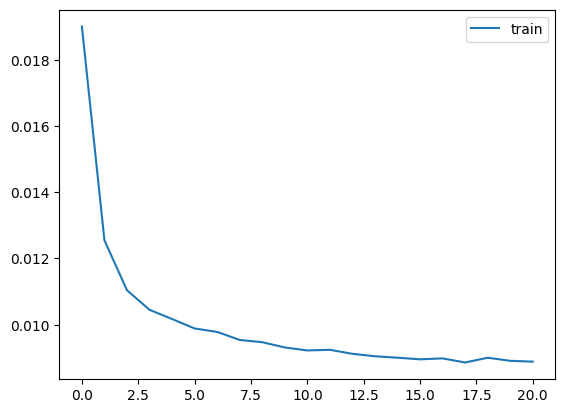

24/24 [==============================] - 1s 2ms/step
MAPE: 9.187527364472407
RMSE: 1636.0770762634343
Correlation 0.740924139639358 with p-value 2.0279684554550667e-130


In [20]:
run_full_model(df_lstm=df_lstm, huang=False, tan=True, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

### Huang

In [21]:
mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=True,
    use_all_predictors=False,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False
)

These are top 5 predictors:  ['sic-60days', 'NAO-60days', 'nat-60days', 'geopotential-60days', 'NationalHolidayFlag']
Top n predictors are used
Top n predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/morgl0l0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/tdj5t7vm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81349', 'data', 'file=/tmp/tmpd26ms1ki/morgl0l0.json', 'init=/tmp/tmpd26ms1ki/tdj5t7vm.json', 'output', 'file=/tmp/tmpd26ms1ki/prophet_model6duk87ub/prophet_model-20240503073355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [82]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

avg rmse 1282.799714325019
avg corr 0.7749828427602554
avg mape 8.369306678715569


Epoch 1/100
3018/3018 - 15s - loss: 0.0116 - 15s/epoch - 5ms/step
Epoch 2/100
3018/3018 - 14s - loss: 0.0085 - 14s/epoch - 4ms/step
Epoch 3/100
3018/3018 - 12s - loss: 0.0081 - 12s/epoch - 4ms/step
Epoch 4/100
3018/3018 - 12s - loss: 0.0080 - 12s/epoch - 4ms/step
Epoch 5/100
3018/3018 - 11s - loss: 0.0079 - 11s/epoch - 4ms/step
Epoch 6/100
3018/3018 - 12s - loss: 0.0078 - 12s/epoch - 4ms/step
Epoch 7/100
3018/3018 - 12s - loss: 0.0077 - 12s/epoch - 4ms/step
Epoch 8/100
3018/3018 - 12s - loss: 0.0077 - 12s/epoch - 4ms/step
Epoch 9/100
3018/3018 - 13s - loss: 0.0076 - 13s/epoch - 4ms/step
Epoch 10/100
3018/3018 - 12s - loss: 0.0075 - 12s/epoch - 4ms/step
Epoch 11/100
3018/3018 - 12s - loss: 0.0075 - 12s/epoch - 4ms/step
Epoch 12/100
3018/3018 - 12s - loss: 0.0074 - 12s/epoch - 4ms/step
Epoch 13/100
3018/3018 - 11s - loss: 0.0074 - 11s/epoch - 4ms/step
Epoch 14/100
3018/3018 - 12s - loss: 0.0074 - 12s/epoch - 4ms/step
Epoch 15/100
3018/3018 - 12s - loss: 0.0074 - 12s/epoch - 4ms/step
Epoc

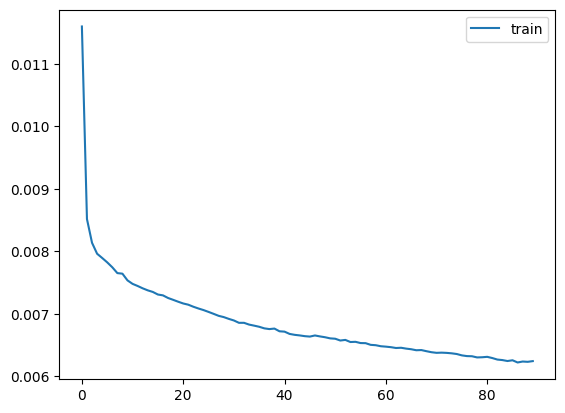

24/24 [==============================] - 0s 2ms/step
MAPE: 6.616062248717107
RMSE: 1229.6022161510514
Correlation 0.8631293688047018 with p-value 2.2992376344395663e-222


In [22]:
run_full_model(df_lstm=df_lstm, huang=True, tan=False, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

# No predictors

### Tan

In [32]:
mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=False,
    use_no_predictors=True,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=False,
    tan=True
)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/dk07bm_8.json


No predictors are used
                       ds  LoadConsumption-60days           y
0     2021-03-02 00:00:00              11313.1375  10937.0525
1     2021-03-02 01:00:00              10925.1475  10833.9750
2     2021-03-02 02:00:00              10576.8200  10807.7400
3     2021-03-02 03:00:00              10371.1225  10970.1925
4     2021-03-02 04:00:00              10420.2075  11400.2950
...                   ...                     ...         ...
24097 2023-11-30 19:00:00              12641.4825  16063.3075
24098 2023-11-30 20:00:00              12091.3375  15370.1250
24099 2023-11-30 21:00:00              11434.7225  14699.8525
24100 2023-11-30 22:00:00              10516.5075  14109.4925
24101 2023-11-30 23:00:00              10033.4825  13508.1750

[24102 rows x 3 columns]
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/hvibj0e0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78603', 'data', 'file=/tmp/tmpd26ms1ki/dk07bm_8.json', 'init=/tmp/tmpd26ms1ki/hvibj0e0.json', 'output', 'file=/tmp/tmpd26ms1ki/prophet_modelcpe86ga7/prophet_model-20240503075325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:53:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:53:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [85]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

avg rmse 1867.1176658648235
avg corr 0.6798723708927062
avg mape 12.211620022911598


Epoch 1/100
3018/3018 - 12s - loss: 0.0189 - 12s/epoch - 4ms/step
Epoch 2/100
3018/3018 - 9s - loss: 0.0137 - 9s/epoch - 3ms/step
Epoch 3/100
3018/3018 - 11s - loss: 0.0120 - 11s/epoch - 4ms/step
Epoch 4/100
3018/3018 - 9s - loss: 0.0111 - 9s/epoch - 3ms/step
Epoch 5/100
3018/3018 - 8s - loss: 0.0107 - 8s/epoch - 3ms/step
Epoch 6/100
3018/3018 - 10s - loss: 0.0103 - 10s/epoch - 3ms/step
Epoch 7/100
3018/3018 - 9s - loss: 0.0101 - 9s/epoch - 3ms/step
Epoch 8/100
3018/3018 - 8s - loss: 0.0100 - 8s/epoch - 3ms/step
Epoch 9/100
3018/3018 - 9s - loss: 0.0099 - 9s/epoch - 3ms/step
Epoch 10/100
3018/3018 - 9s - loss: 0.0098 - 9s/epoch - 3ms/step
Epoch 11/100
3018/3018 - 8s - loss: 0.0096 - 8s/epoch - 3ms/step
Epoch 12/100
3018/3018 - 9s - loss: 0.0096 - 9s/epoch - 3ms/step
Epoch 13/100
3018/3018 - 8s - loss: 0.0095 - 8s/epoch - 3ms/step
Epoch 14/100
3018/3018 - 10s - loss: 0.0094 - 10s/epoch - 3ms/step
Epoch 15/100
3018/3018 - 10s - loss: 0.0094 - 10s/epoch - 3ms/step
Epoch 16/100
3018/3018 -

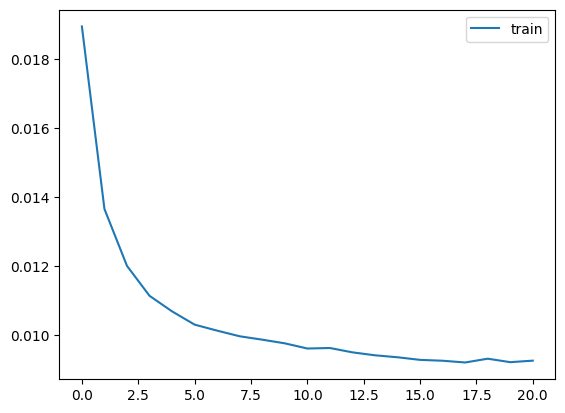

24/24 [==============================] - 1s 2ms/step
MAPE: 9.343828264244237
RMSE: 1653.6798542354109
Correlation 0.6903262997461681 with p-value 2.135384590926836e-106


In [33]:
run_full_model(df_lstm=df_lstm, huang=False, tan=True, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

### Huang

In [40]:
mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=False,
    use_no_predictors=True,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False
)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/_p3d1kzc.json


No predictors are used
                       ds  LoadConsumption-60days           y
0     2021-03-02 00:00:00              11313.1375  10937.0525
1     2021-03-02 01:00:00              10925.1475  10833.9750
2     2021-03-02 02:00:00              10576.8200  10807.7400
3     2021-03-02 03:00:00              10371.1225  10970.1925
4     2021-03-02 04:00:00              10420.2075  11400.2950
...                   ...                     ...         ...
24097 2023-11-30 19:00:00              12641.4825  16063.3075
24098 2023-11-30 20:00:00              12091.3375  15370.1250
24099 2023-11-30 21:00:00              11434.7225  14699.8525
24100 2023-11-30 22:00:00              10516.5075  14109.4925
24101 2023-11-30 23:00:00              10033.4825  13508.1750

[24102 rows x 3 columns]
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpd26ms1ki/ncfdo7ye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40031', 'data', 'file=/tmp/tmpd26ms1ki/_p3d1kzc.json', 'init=/tmp/tmpd26ms1ki/ncfdo7ye.json', 'output', 'file=/tmp/tmpd26ms1ki/prophet_modelb3r4ttjf/prophet_model-20240503080417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:04:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:04:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [88]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

avg rmse 1588.7296060927274
avg corr 0.7444394380838296
avg mape 10.560829728729288


Epoch 1/100
3018/3018 - 16s - loss: 0.0129 - 16s/epoch - 5ms/step
Epoch 2/100
3018/3018 - 14s - loss: 0.0087 - 14s/epoch - 5ms/step
Epoch 3/100
3018/3018 - 11s - loss: 0.0084 - 11s/epoch - 4ms/step
Epoch 4/100
3018/3018 - 11s - loss: 0.0082 - 11s/epoch - 4ms/step
Epoch 5/100
3018/3018 - 13s - loss: 0.0080 - 13s/epoch - 4ms/step
Epoch 6/100
3018/3018 - 12s - loss: 0.0079 - 12s/epoch - 4ms/step
Epoch 7/100
3018/3018 - 13s - loss: 0.0078 - 13s/epoch - 4ms/step
Epoch 8/100
3018/3018 - 12s - loss: 0.0077 - 12s/epoch - 4ms/step
Epoch 9/100
3018/3018 - 14s - loss: 0.0077 - 14s/epoch - 4ms/step
Epoch 10/100
3018/3018 - 12s - loss: 0.0077 - 12s/epoch - 4ms/step
Epoch 11/100
3018/3018 - 12s - loss: 0.0076 - 12s/epoch - 4ms/step
Epoch 12/100
3018/3018 - 12s - loss: 0.0075 - 12s/epoch - 4ms/step
Epoch 13/100
3018/3018 - 12s - loss: 0.0075 - 12s/epoch - 4ms/step
Epoch 14/100
3018/3018 - 13s - loss: 0.0075 - 13s/epoch - 4ms/step
Epoch 15/100
3018/3018 - 12s - loss: 0.0074 - 12s/epoch - 4ms/step
Epoc

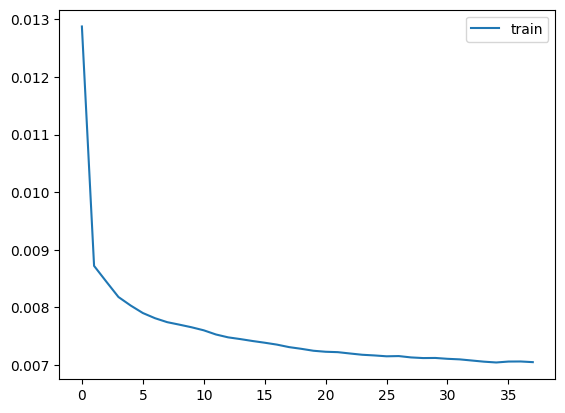

24/24 [==============================] - 0s 3ms/step
MAPE: 8.043325321461833
RMSE: 1452.560284256036
Correlation 0.7924755404770378 with p-value 1.7026262754037661e-161


In [41]:
# df_lstm.reset_index(inplace=True)
run_full_model(df_lstm=df_lstm, huang=True, tan=False, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

# Visualization of model

In [90]:
!pip install visualkeras

In [91]:
model = Sequential()
model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
model.add(LSTM(30, activation='sigmoid', return_sequences=True, name='LSTM_Layer_1'))
model.add(Dropout(rate=0.2, name='Dropout_Layer_0.2'))
model.add(LSTM(60, activation='tanh', name='LSTM_Layer_2'))
model.add(Dropout(rate=0.3, name='Dropout_Layer_0.3'))
model.add(Dense(1, activation='linear', name='Dense_Layer'))
model.compile(optimizer='rmsprop', loss='mse')

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


NameError: name 'plot_model' is not defined

In [ ]:
# from tensorflow.keras.utils import plot_model

# model = Sequential()
# model.add(LSTM(30, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), name='LSTM1'))
# model.add(LSTM(90, activation='relu', name='LSTM2'))
# model.add(Dense(1, name='Dense'))
# model.compile(optimizer='adam', loss='mse')

# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# # plot_model(model, show_shapes=True, show_layer_names=True) # to_file='/content/drive/MyDrive/master_thesis_data/preprocessed_data.csv.png',



# MLR

### All predictors

In [ ]:
df = read_processed_data()
df_flagged = create_national_holiday_and_event_flag(df)
numerical_columns = find_numerical_columns(df_flagged)

df_flagged_outliers_cleared = clear_outliers(df_flagged, numerical_columns=['LoadConsumption'], start_winter=start_test_wintertime)

df_lag = shift_data(df_flagged_outliers_cleared, n_days_lag)

(df_test, df_train_val) = split_train_val_test(df_lag, start_test_wintertime)

(df_train_val, df_test, numerical_columns_lagged) = impute_numerical_columns(df_train_val, df_test, numerical_columns, n_days_lag)

df_train_val.set_index('DateUTC', inplace=True)
df_test.set_index('DateUTC', inplace=True)

# scale data
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(df_train_val)
df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

df_test = df_test[df_train_val.columns]
test_scaled = scaler.transform(df_test)
df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

# reorder columns
cols_ordered = list(df_train_scaled)
cols_ordered.remove('LoadConsumption_scaled')
cols_ordered.append('LoadConsumption_scaled')
df_train_scaled = df_train_scaled[cols_ordered]
df_test_scaled = df_test_scaled[cols_ordered]

# split into X and y
train_values = df_train_scaled.values
test_values = df_test_scaled.values

train_X, train_y = train_values[:, :-1], train_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]


In [ ]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(train_X, train_y)
pred = LR.predict(test_X)

yhat_inversed = inverse_transform_predictions(scaler=scaler, data=pred, colName='LoadConsumption_scaled', colNames=df_train_scaled.columns)
mape, rmse, corr_test, p_value_test = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)

### Top n predictors

In [ ]:
df = read_processed_data()
df_flagged = create_national_holiday_and_event_flag(df)
numerical_columns = find_numerical_columns(df_flagged)

df_flagged_outliers_cleared = clear_outliers(df_flagged, numerical_columns=['LoadConsumption'], start_winter=start_test_wintertime)

df_lag = shift_data(df_flagged_outliers_cleared, n_days_lag)

(df_test, df_train_val) = split_train_val_test(df_lag, start_test_wintertime)

(df_train_val, df_test, numerical_columns_lagged) = impute_numerical_columns(df_train_val, df_test, numerical_columns, n_days_lag)

predictors_dict, predictors_list = select_top_n_correlated_predictors(df_train_val, numerical_columns_lagged, n_predictors, alpha)
cols_to_select = predictors_list.copy()
cols_to_select.append('DateUTC')
cols_to_select.append('LoadConsumption')
df_train_val = df_train_val[cols_to_select]
df_test = df_test[cols_to_select]


df_train_val.set_index('DateUTC', inplace=True)
df_test.set_index('DateUTC', inplace=True)

# scale data
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(df_train_val)
df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

df_test = df_test[df_train_val.columns]
test_scaled = scaler.transform(df_test)
df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

# reorder columns
cols_ordered = list(df_train_scaled)
cols_ordered.remove('LoadConsumption_scaled')
cols_ordered.append('LoadConsumption_scaled')
df_train_scaled = df_train_scaled[cols_ordered]
df_test_scaled = df_test_scaled[cols_ordered]

# split into X and y
train_values = df_train_scaled.values
test_values = df_test_scaled.values

train_X, train_y = train_values[:, :-1], train_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]

In [ ]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(train_X, train_y)
pred = LR.predict(test_X)

yhat_inversed = inverse_transform_predictions(scaler=scaler, data=pred, colName='LoadConsumption_scaled', colNames=df_train_scaled.columns)
mape, rmse, corr_test, p_value_test = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)

### No predictors

In [ ]:
df = read_processed_data()
df_flagged = create_national_holiday_and_event_flag(df)
numerical_columns = find_numerical_columns(df_flagged)

df_flagged_outliers_cleared = clear_outliers(df_flagged, numerical_columns=['LoadConsumption'], start_winter=start_test_wintertime)

df_lag = shift_data(df_flagged_outliers_cleared, n_days_lag)

(df_test, df_train_val) = split_train_val_test(df_lag, start_test_wintertime)

(df_train_val, df_test, numerical_columns_lagged) = impute_numerical_columns(df_train_val, df_test, numerical_columns, n_days_lag)


df_train_val = df_train_val[['DateUTC', 'LoadConsumption', f'LoadConsumption-{n_days_lag}days']]
df_test = df_test[['DateUTC', 'LoadConsumption', f'LoadConsumption-{n_days_lag}days']]

df_train_val.set_index('DateUTC', inplace=True)
df_test.set_index('DateUTC', inplace=True)

# scale data
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(df_train_val)
df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

df_test = df_test[df_train_val.columns]
test_scaled = scaler.transform(df_test)
df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

# reorder columns
cols_ordered = list(df_train_scaled)
cols_ordered.remove('LoadConsumption_scaled')
cols_ordered.append('LoadConsumption_scaled')
df_train_scaled = df_train_scaled[cols_ordered]
df_test_scaled = df_test_scaled[cols_ordered]

# split into X and y
train_values = df_train_scaled.values
test_values = df_test_scaled.values

train_X, train_y = train_values[:, :-1], train_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]

In [ ]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(train_X, train_y)
pred = LR.predict(test_X)

yhat_inversed = inverse_transform_predictions(scaler=scaler, data=pred, colName='LoadConsumption_scaled', colNames=df_train_scaled.columns)
mape, rmse, corr_test, p_value_test = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)